In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# # # Import libraries

Import all the necessary libraries. 

There are 9 different fishes to classify.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



In [5]:
import os
from pathlib import Path

file_path = Path('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/')
file_content = list(file_path.glob(r'**/*.png'))

#create labels as per the label name

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_content))

In [6]:
file_content = pd.Series(file_content).astype(str)
labels = pd.Series(labels)

In [7]:
df = pd.concat([file_content, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [8]:
#shape of the dataset

df.shape

(18000, 2)

# # # Visualizing the data 

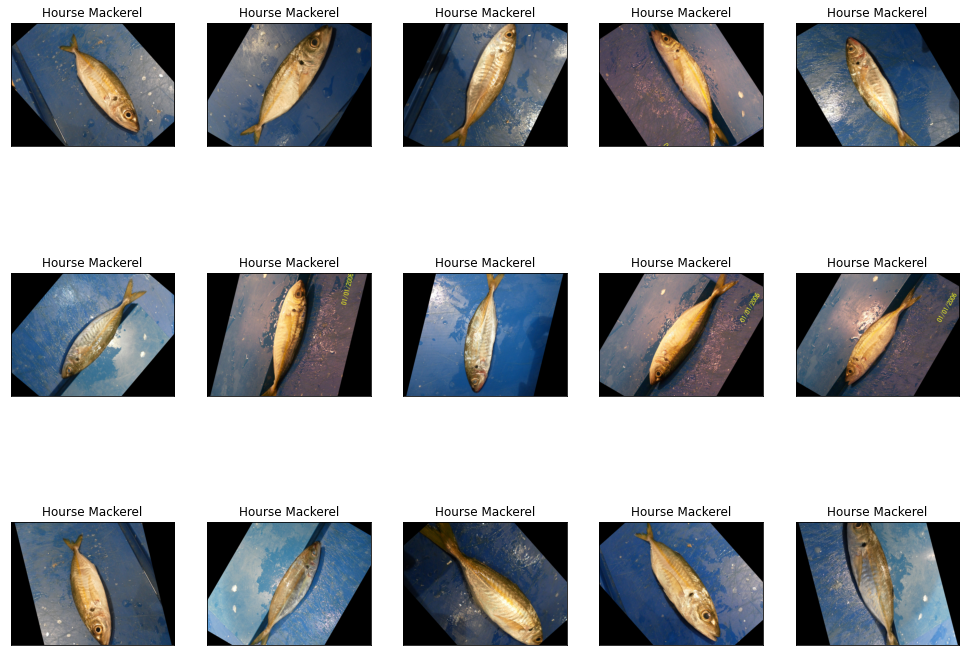

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(17,13), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

Hourse Mackerel          1000
Hourse Mackerel GT       1000
Red Sea Bream            1000
Gilt-Head Bream          1000
Gilt-Head Bream GT       1000
Shrimp                   1000
Shrimp GT                1000
Striped Red Mullet       1000
Striped Red Mullet GT    1000
Trout GT                 1000
Trout                    1000
Red Mullet GT            1000
Red Mullet               1000
Sea Bass GT              1000
Sea Bass                 1000
Black Sea Sprat          1000
Black Sea Sprat GT       1000
Red Sea Bream GT         1000
Name: label, dtype: int64


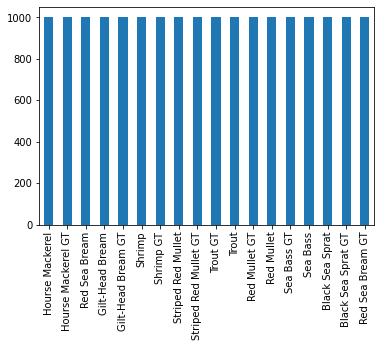

In [10]:
df['label'].value_counts().plot.bar()
print(df['label'].value_counts())

Remove the ground truth as we dont need them.

In [11]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: label, dtype: int64

# # # Split the data

In [12]:
# split the data into training and validation set


from sklearn.model_selection import train_test_split 

x_train, x_test = train_test_split(df, test_size=0.3, random_state=42)
x_train, x_val = train_test_split(x_train, test_size =0.3, random_state=42)



In [13]:
print("The shape of training data", x_train.shape)
print("The shape of validation data", x_val.shape)
print("The shape of test data", x_test.shape)

The shape of training data (4410, 2)
The shape of validation data (1890, 2)
The shape of test data (2700, 2)


## # # Model creation

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,
    x_col='image',
    y_col='label',
    target_size=(150,150),
    class_mode='categorical' ,
    batch_size = 128
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = x_val,
    x_col = 'image',
    y_col = 'label',
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 64
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = x_test,
    x_col = 'image',
    y_col = 'label',
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 4410 validated image filenames belonging to 9 classes.
Found 1890 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                          input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
    
])

2021-10-28 14:37:59.473939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:37:59.573339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:37:59.574049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:37:59.575837: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])



In [18]:
history = model.fit(train_generator,
                   epochs=30,
                   steps_per_epoch=34,
                   validation_data = validation_generator,
                   validation_steps = 30,
                   verbose=1)

model.save('fish-classification.h5')

2021-10-28 14:38:06.979472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-28 14:38:12.196357: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


34/34 [==============================] - 161s 5s/step - loss: 2.1124 - accuracy: 0.1707 - val_loss: 1.8799 - val_accuracy: 0.2524
Epoch 2/30
34/34 [==============================] - 84s 2s/step - loss: 1.8185 - accuracy: 0.3020 - val_loss: 1.6249 - val_accuracy: 0.3302
Epoch 3/30
34/34 [==============================] - 84s 2s/step - loss: 1.4207 - accuracy: 0.4601 - val_loss: 1.0608 - val_accuracy: 0.5979
Epoch 4/30
34/34 [==============================] - 85s 3s/step - loss: 1.1207 - accuracy: 0.5722 - val_loss: 0.8332 - val_accuracy: 0.6899
Epoch 5/30
34/34 [==============================] - 86s 3s/step - loss: 0.9305 - accuracy: 0.6446 - val_loss: 0.6797 - val_accuracy: 0.7656
Epoch 6/30
34/34 [==============================] - 87s 3s/step - loss: 0.8634 - accuracy: 0.6656 - val_loss: 0.7195 - val_accuracy: 0.7196
Epoch 7/30
34/34 [==============================] - 87s 3s/step - loss: 0.7279 - accuracy: 0.7258 - val_loss: 0.5232 - val_accuracy: 0.7979
Epoch 8/30
34/34 [============

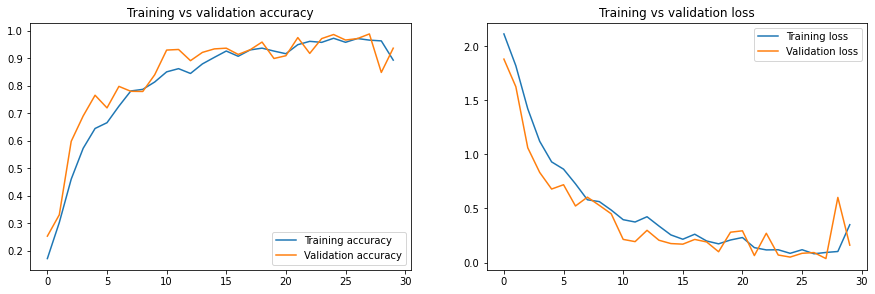

In [19]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

# # # Prediction

In [20]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)
labels = train_generator.class_indices
labels = dict((v,k) for k, v in labels.items())
y_pred = [labels[k] for k in pred]


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(x_test.label, y_pred))

print(confusion_matrix(x_test.label, y_pred))


                    precision    recall  f1-score   support

   Black Sea Sprat       0.11      0.10      0.10       326
   Gilt-Head Bream       0.08      0.07      0.07       297
   Hourse Mackerel       0.14      0.12      0.13       300
        Red Mullet       0.09      0.09      0.09       288
     Red Sea Bream       0.11      0.10      0.11       294
          Sea Bass       0.11      0.14      0.12       287
            Shrimp       0.12      0.12      0.12       314
Striped Red Mullet       0.10      0.10      0.10       298
             Trout       0.11      0.12      0.12       296

          accuracy                           0.11      2700
         macro avg       0.11      0.11      0.11      2700
      weighted avg       0.11      0.11      0.11      2700

[[33 35 36 42 26 44 34 37 39]
 [34 20 23 32 32 43 37 35 41]
 [40 16 37 29 34 41 40 23 40]
 [28 30 33 26 18 41 41 35 36]
 [38 30 23 30 30 50 23 40 30]
 [37 33 30 26 24 40 36 26 35]
 [36 32 27 36 40 36 37 34 36]
 [31 35

In [22]:
test_accuracy = model.evaluate(test_generator)[1]


43/43 [==============================] - 28s 642ms/step - loss: 0.1506 - accuracy: 0.9470


The acccuracy of 94% has been achieved.